In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/logistics-operations-database/routes.csv
/kaggle/input/logistics-operations-database/facilities.csv
/kaggle/input/logistics-operations-database/drivers.csv
/kaggle/input/logistics-operations-database/DATABASE_SCHEMA.txt
/kaggle/input/logistics-operations-database/trips.csv
/kaggle/input/logistics-operations-database/safety_incidents.csv
/kaggle/input/logistics-operations-database/trailers.csv
/kaggle/input/logistics-operations-database/delivery_events.csv
/kaggle/input/logistics-operations-database/driver_monthly_metrics.csv
/kaggle/input/logistics-operations-database/trucks.csv
/kaggle/input/logistics-operations-database/loads.csv
/kaggle/input/logistics-operations-database/fuel_purchases.csv
/kaggle/input/logistics-operations-database/truck_utilization_metrics.csv
/kaggle/input/logistics-operations-database/customers.csv
/kaggle/input/logistics-operations-database/maintenance_records.csv


# **Changing Section to Rcode**

In [11]:

# ---- Helpful libraries ----
# (Kaggle's R image already includes many of these; install only if missing)
pkgs <- c("tidyverse", "readr", "fs")
to_install <- pkgs[!pkgs %in% installed.packages()[, "Package"]]
if (length(to_install)) install.packages(to_install, dependencies = TRUE)

library(tidyverse)
library(readr)
library(fs)

# ---- Paths ----
input_dir   <- "/kaggle/input"      # read-only datasets
working_dir <- "/kaggle/working"    # persists when you Save & Run All
temp_dir    <- "/kaggle/temp"       # ephemeral (cleared after session)

# ---- List all files under /kaggle/input (recursive) ----
# Equivalent to Python's os.walk print
all_input_files <- dir_ls(input_dir, recurse = TRUE, type = "file")
print(all_input_files)

# If you want just the dataset you attached, set its subdirectory explicitly:
# dataset_dir <- "/kaggle/input/logistics-operations-database"
# dir_ls(dataset_dir, recurse = TRUE, type = "file")


/kaggle/input/logistics-operations-database/DATABASE_SCHEMA.txt
/kaggle/input/logistics-operations-database/customers.csv
/kaggle/input/logistics-operations-database/delivery_events.csv
/kaggle/input/logistics-operations-database/driver_monthly_metrics.csv
/kaggle/input/logistics-operations-database/drivers.csv
/kaggle/input/logistics-operations-database/facilities.csv
/kaggle/input/logistics-operations-database/fuel_purchases.csv
/kaggle/input/logistics-operations-database/loads.csv
/kaggle/input/logistics-operations-database/maintenance_records.csv
/kaggle/input/logistics-operations-database/routes.csv
/kaggle/input/logistics-operations-database/safety_incidents.csv
/kaggle/input/logistics-operations-database/trailers.csv
/kaggle/input/logistics-operations-database/trips.csv
/kaggle/input/logistics-operations-database/truck_utilization_metrics.csv
/kaggle/input/logistics-operations-database/trucks.csv


In [89]:

library(DBI); library(duckdb)
con <- dbConnect(duckdb::duckdb(), dbdir=":memory:")
duckdb::duckdb_register(con, "customers", customers)
duckdb::duckdb_register(con, "delivery_events", delivery_events)

duckdb::duckdb_register(con, "drivers", drivers)
duckdb::duckdb_register(con, "facilities", facilities)

duckdb::duckdb_register(con, "routes", routes)  
duckdb::duckdb_register(con, "trips", trips) 
duckdb::duckdb_register(con, "trucks", trucks)


# Load all CSVs file to R data frames

In [103]:

# -------------------------------
# Load ALL logistics CSVs into R data frames
# and register them with DuckDB (zero-copy)
# -------------------------------
pkgs <- c("readr","janitor","fs","purrr","dplyr","stringr","DBI","duckdb")
to_install <- pkgs[!pkgs %in% installed.packages()[,"Package"]]
if (length(to_install)) install.packages(to_install, dependencies = TRUE)

library(readr); library(janitor); library(fs)
library(purrr); library(dplyr); library(stringr)
library(DBI);  library(duckdb)

# Always use strings or comments for paths; do NOT leave raw paths alone in a cell
dataset_dir <- "/kaggle/input/logistics-operations-database"

# Helper reader with light cleaning
read_clean_csv <- function(path) {
  readr::read_csv(path, show_col_types = FALSE, guess_max = 100000) |>
    janitor::clean_names()
}

# Map R object names -> filenames
files <- c(
  customers                 = "customers.csv",
  delivery_events           = "delivery_events.csv",
  driver_monthly_metrics    = "driver_monthly_metrics.csv",
  drivers                   = "drivers.csv",
  facilities                = "facilities.csv",
  fuel_purchases            = "fuel_purchases.csv",
  loads                     = "loads.csv",
  maintenance_records       = "maintenance_records.csv",
  routes                    = "routes.csv",
  safety_incidents          = "safety_incidents.csv",
  trailers                  = "trailers.csv",
  trips                     = "trips.csv",
  truck_utilization_metrics = "truck_utilization_metrics.csv",
  trucks                    = "trucks.csv"
)


# Status report
status <- tibble::tibble(
  object = names(files),
  file   = unname(files),
  exists_in_R = vapply(names(files), function(nm) exists(nm, inherits = TRUE), logical(1)),
  nrows = vapply(names(files), function(nm) if (exists(nm, inherits = TRUE)) nrow(get(nm)) else NA_integer_, integer(1))
)
print(status)


# A tibble: 14 × 4
   object                    file                          exists_in_R  nrows
   <chr>                     <chr>                         <lgl>        <int>
 1 customers                 customers.csv                 TRUE           200
 2 delivery_events           delivery_events.csv           TRUE        170820
 3 driver_monthly_metrics    driver_monthly_metrics.csv    TRUE          4464
 4 drivers                   drivers.csv                   TRUE           150
 5 facilities                facilities.csv                TRUE            50
 6 fuel_purchases            fuel_purchases.csv            TRUE        196442
 7 loads                     loads.csv                     TRUE         85410
 8 maintenance_records       maintenance_records.csv       TRUE          2920
 9 routes                    routes.csv                    TRUE            58
10 safety_incidents          safety_incidents.csv          TRUE           170
11 trailers                  trailers.csv    

# Exploratory Data Analysis

In [291]:
glimpse(driver_monthly_metrics)


Rows: 4,464
Columns: 9
$ driver_id             <chr> "DRV00001", "DRV00001", "DRV00001", "DRV00001", …
$ month                 <date> 2022-01-01, 2022-02-01, 2022-03-01, 2022-04-01,…
$ trips_completed       <dbl> 26, 9, 20, 19, 14, 13, 21, 20, 20, 12, 16, 16, 1…
$ total_miles           <dbl> 36620, 13515, 30361, 28127, 16071, 17291, 32772,…
$ total_revenue         <dbl> 79141.59, 27133.87, 62399.62, 68161.13, 36256.82…
$ average_mpg           <dbl> 6.61, 6.69, 6.36, 6.61, 6.35, 6.38, 6.41, 6.35, …
$ total_fuel_gallons    <dbl> 5574.7, 2095.1, 4792.2, 4251.4, 2573.1, 2767.8, …
$ on_time_delivery_rate <dbl> 0.385, 0.333, 0.550, 0.474, 0.214, 0.615, 0.476,…
$ average_idle_hours    <dbl> 8.2, 6.8, 7.5, 8.4, 6.8, 5.5, 7.5, 5.8, 5.8, 7.0…


In [297]:
library(knitr)

dmm <- read_clean_csv(file.path(dataset_dir, "driver_monthly_metrics.csv")) |>
  janitor::clean_names()

dmm %>%
  head(10) %>%
  kable()




|driver_id |month      | trips_completed| total_miles| total_revenue| average_mpg| total_fuel_gallons| on_time_delivery_rate| average_idle_hours|
|:---------|:----------|---------------:|-----------:|-------------:|-----------:|------------------:|---------------------:|------------------:|
|DRV00001  |2022-01-01 |              26|       36620|      79141.59|        6.61|             5574.7|                 0.385|                8.2|
|DRV00001  |2022-02-01 |               9|       13515|      27133.87|        6.69|             2095.1|                 0.333|                6.8|
|DRV00001  |2022-03-01 |              20|       30361|      62399.62|        6.36|             4792.2|                 0.550|                7.5|
|DRV00001  |2022-04-01 |              19|       28127|      68161.13|        6.61|             4251.4|                 0.474|                8.4|
|DRV00001  |2022-05-01 |              14|       16071|      36256.82|        6.35|             2573.1|                 0.2

# **Driver-Level Performance Snapshot**

In [288]:
library(knitr)

driver_monthly_metrics %>%
  group_by(driver_id) %>%
  summarise(
    total_miles    = sum(total_miles, na.rm = TRUE),
    total_fuel     = sum(total_fuel_gallons, na.rm = TRUE),
    total_revenue  = sum(total_revenue, na.rm = TRUE),
    .groups = "drop"
  ) %>%
  arrange(desc(total_revenue)) %>%
  head(10) %>%
  mutate(
    total_miles   = round(total_miles, 2),
    total_fuel    = round(total_fuel, 2),
    total_revenue = scales::dollar(total_revenue)
  ) %>%
  kable(
    col.names = c(
      "Driver ID",
      "Total Miles",
      "Total Fuel Gallons",
      "Total Revenue"
    )
  )




|Driver ID | Total Miles| Total Fuel Gallons|Total Revenue |
|:---------|-----------:|------------------:|:-------------|
|DRV00051  |     1074677|           167024.2|$2,311,844    |
|DRV00108  |     1073445|           166238.4|$2,311,328    |
|DRV00059  |     1064844|           164582.5|$2,305,057    |
|DRV00016  |     1042631|           161679.1|$2,278,575    |
|DRV00019  |     1060268|           165029.7|$2,275,655    |
|DRV00127  |     1047108|           162594.5|$2,272,318    |
|DRV00149  |     1059718|           164156.8|$2,269,106    |
|DRV00147  |     1039157|           161429.3|$2,256,067    |
|DRV00085  |     1034233|           160210.2|$2,229,521    |
|DRV00087  |     1029613|           159277.4|$2,214,003    |

# KPI Summary

In [310]:
library(knitr)

kpi_summary %>%
  mutate(
    on_time_delivery_rate = on_time_deliveries / pmax(total_deliveries, 1),
    total_revenue = scales::dollar(total_revenue),
    avg_revenue_per_mile = scales::dollar(avg_revenue_per_mile),
    on_time_delivery_rate = scales::percent(on_time_delivery_rate, accuracy = 0.01)
  ) %>%
  select(
    total_deliveries,
    on_time_deliveries,
    on_time_delivery_rate,
    total_fuel_gallons,
    total_miles,
    total_revenue,
    driver_mpg,
    avg_revenue_per_mile
  ) %>%
  kable(
    col.names = c(
      "Total Deliveries",
      "On-Time Deliveries",
      "On-Time Delivery Rate",
      "Total Fuel Gallons",
      "Total Miles",
      "Total Revenue",
      "Driver MPG",
      "Avg Revenue per Mile"
    )
  )




| Total Deliveries| On-Time Deliveries|On-Time Delivery Rate | Total Fuel Gallons| Total Miles|Total Revenue | Driver MPG|Avg Revenue per Mile |
|----------------:|------------------:|:---------------------|------------------:|-----------:|:-------------|----------:|:--------------------|
|           170820|              95095|55.67%                |           18564132|   119692305|$257,264,551  |       6.45|$2.15                |

# On-Time Performance Summary

In [287]:
library(knitr)

driver_monthly_metrics %>%
  summarise(
    avg_on_time_rate = mean(on_time_delivery_rate, na.rm = TRUE),
    min_on_time_rate = min(on_time_delivery_rate, na.rm = TRUE),
    max_on_time_rate = max(on_time_delivery_rate, na.rm = TRUE)
  ) %>%
  mutate(across(everything(), ~ scales::percent(.x, accuracy = 0.1))) %>%
  kable(
    col.names = c(
      "Average On-Time Rate",
      "Minimum On-Time Rate",
      "Maximum On-Time Rate"
    )
  )




|Average On-Time Rate |Minimum On-Time Rate |Maximum On-Time Rate |
|:--------------------|:--------------------|:--------------------|
|44.6%                |0.0%                 |83.3%                |

# Driver(DRV00001): 2024 Monthly Metrics

In [303]:
library(knitr)

driver_monthly_metrics %>%
  filter(
    driver_id == "DRV00001",
    as.Date(month) >= as.Date("2024-01-01"),
    as.Date(month) <  as.Date("2025-01-01")
  ) %>%
  mutate(
    date               = as.Date(month),
    delivery_rate      = scales::percent(on_time_delivery_rate, accuracy = 0.1),
    average_idle_hours = round(average_idle_hours, 2),
    average_mpg        = round(average_mpg, 2),
    total_revenue      = scales::dollar(total_revenue)
  ) %>%
  select(
    driver_id,
    date,
    delivery_rate,
    average_idle_hours,
    average_mpg,
    trips_completed,
    total_miles,
    total_revenue
  ) %>%
  arrange(date) %>%
  kable(
    col.names = c(
      "Driver ID",
      "Date",
      "On-Time Delivery Rate",
      "Avg Idle Hours",
      "Average MPG",
      "Trips Completed",
      "Total Miles",
      "Total Revenue"
    )
  )




|Driver ID |Date       |On-Time Delivery Rate | Avg Idle Hours| Average MPG| Trips Completed| Total Miles|Total Revenue |
|:---------|:----------|:---------------------|--------------:|-----------:|---------------:|-----------:|:-------------|
|DRV00001  |2024-01-01 |27.3%                 |            6.7|        6.36|              22|       36993|$79,177.37    |
|DRV00001  |2024-02-01 |40.0%                 |            6.8|        6.51|              15|       25006|$53,929.55    |
|DRV00001  |2024-03-01 |33.3%                 |            6.9|        6.40|              27|       36821|$77,435.61    |
|DRV00001  |2024-04-01 |52.9%                 |            7.0|        6.32|              17|       25192|$50,274.69    |
|DRV00001  |2024-05-01 |60.9%                 |            6.4|        6.61|              23|       36131|$75,314.62    |
|DRV00001  |2024-06-01 |52.6%                 |            7.2|        6.86|              19|       29615|$58,603.31    |
|DRV00001  |2024-07-01

#  Driver(DRV00001) : Mile & MPG 2024 Monthly Trend 

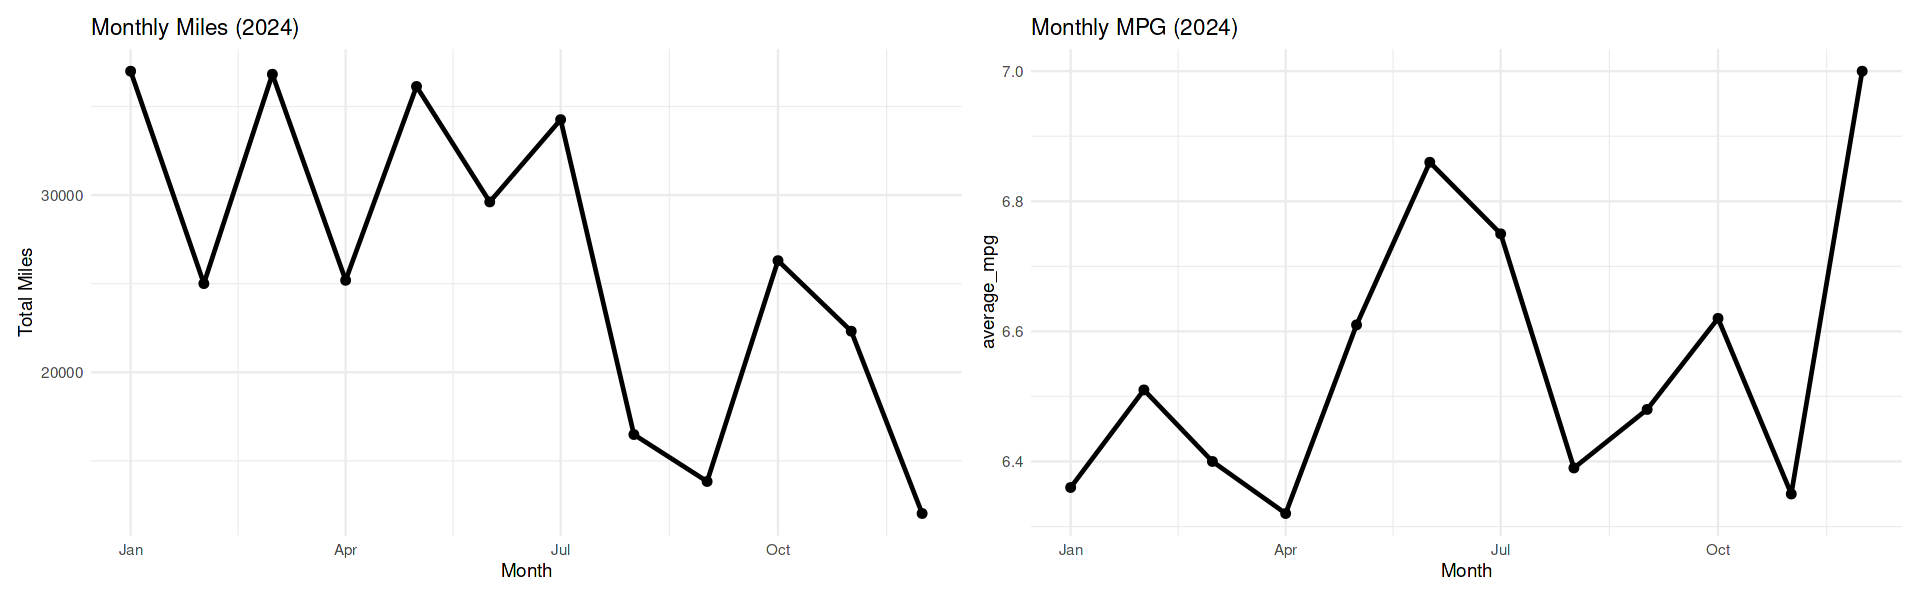

In [246]:
library(ggplot2)
library(patchwork)

mpg_col <- grep("mpg", names(driver_monthly_metrics), value=TRUE, ignore.case=TRUE)[1]
df <- driver_monthly_metrics %>%
  filter(driver_id=="DRV00001",
         as.Date(month)>=as.Date("2024-01-01"),
         as.Date(month)< as.Date("2025-01-01"))

p1 <- ggplot(df, aes(as.Date(month), total_miles)) +
  geom_line(linewidth=1) + geom_point(size=2) +
  labs(title="Monthly Miles (2024)", x="Month", y="Total Miles") +
  theme_minimal()

p2 <- ggplot(df, aes(as.Date(month), .data[[mpg_col]])) +
  geom_line(linewidth=1) + geom_point(size=2) +
  labs(title="Monthly MPG (2024)", x="Month", y=mpg_col) +
  theme_minimal()

p1 + scale_x_date(date_labels="%b") | p2 + scale_x_date(date_labels="%b")


# Percentile rank MoM change (Revenue per Mile)

In [312]:
library(knitr)

pct_change %>%
  select(driver_id, month, rev_per_mile, pct_rank, pct_rank_mom_change) %>%
  mutate(across(c(rev_per_mile, pct_rank, pct_rank_mom_change), ~ round(.x, 4))) %>%
  head(10) %>% kable()




|driver_id |month      | rev_per_mile| pct_rank| pct_rank_mom_change|
|:---------|:----------|------------:|--------:|-------------------:|
|DRV00001  |2022-01-01 |       2.1612|   0.5528|                  NA|
|DRV00001  |2022-02-01 |       2.0077|   0.1545|             -0.3984|
|DRV00001  |2022-03-01 |       2.0553|   0.1870|              0.0325|
|DRV00001  |2022-04-01 |       2.4233|   0.9756|              0.7886|
|DRV00001  |2022-05-01 |       2.2560|   0.8293|             -0.1463|
|DRV00001  |2022-06-01 |       2.2966|   0.9350|              0.1057|
|DRV00001  |2022-07-01 |       2.0400|   0.2114|             -0.7236|
|DRV00001  |2022-08-01 |       2.1664|   0.5041|              0.2927|
|DRV00001  |2022-09-01 |       2.3336|   0.9024|              0.3984|
|DRV00001  |2022-10-01 |       2.2343|   0.8293|             -0.0732|

# Biggest movers (top 10 increases / decreases)

In [317]:
pct_change %>%
  filter(!is.na(pct_rank_mom_change)) %>%
  arrange(desc(pct_rank_mom_change)) %>%
  select(driver_id, month, pct_rank_mom_change) %>%
  head(10) %>%
  mutate(
    `Percentile Change` = scales::percent(pct_rank_mom_change, accuracy = 0.01)
  ) %>%
  select(driver_id, month, `Percentile Change`) %>%
  kable(
    col.names = c("Driver ID", "Month", "Percentile Rank Change")
  )




|Driver ID |Month      |Percentile Rank Change |
|:---------|:----------|:----------------------|
|DRV00005  |2022-07-01 |100.00%                |
|DRV00041  |2024-10-01 |97.56%                 |
|DRV00125  |2023-11-01 |95.93%                 |
|DRV00059  |2023-01-01 |93.50%                 |
|DRV00104  |2023-01-01 |93.50%                 |
|DRV00009  |2023-03-01 |92.68%                 |
|DRV00111  |2023-08-01 |92.68%                 |
|DRV00114  |2024-05-01 |92.68%                 |
|DRV00065  |2022-11-01 |91.87%                 |
|DRV00060  |2023-09-01 |91.06%                 |

# Top 10 Positive MoM Percentile Rank Changes

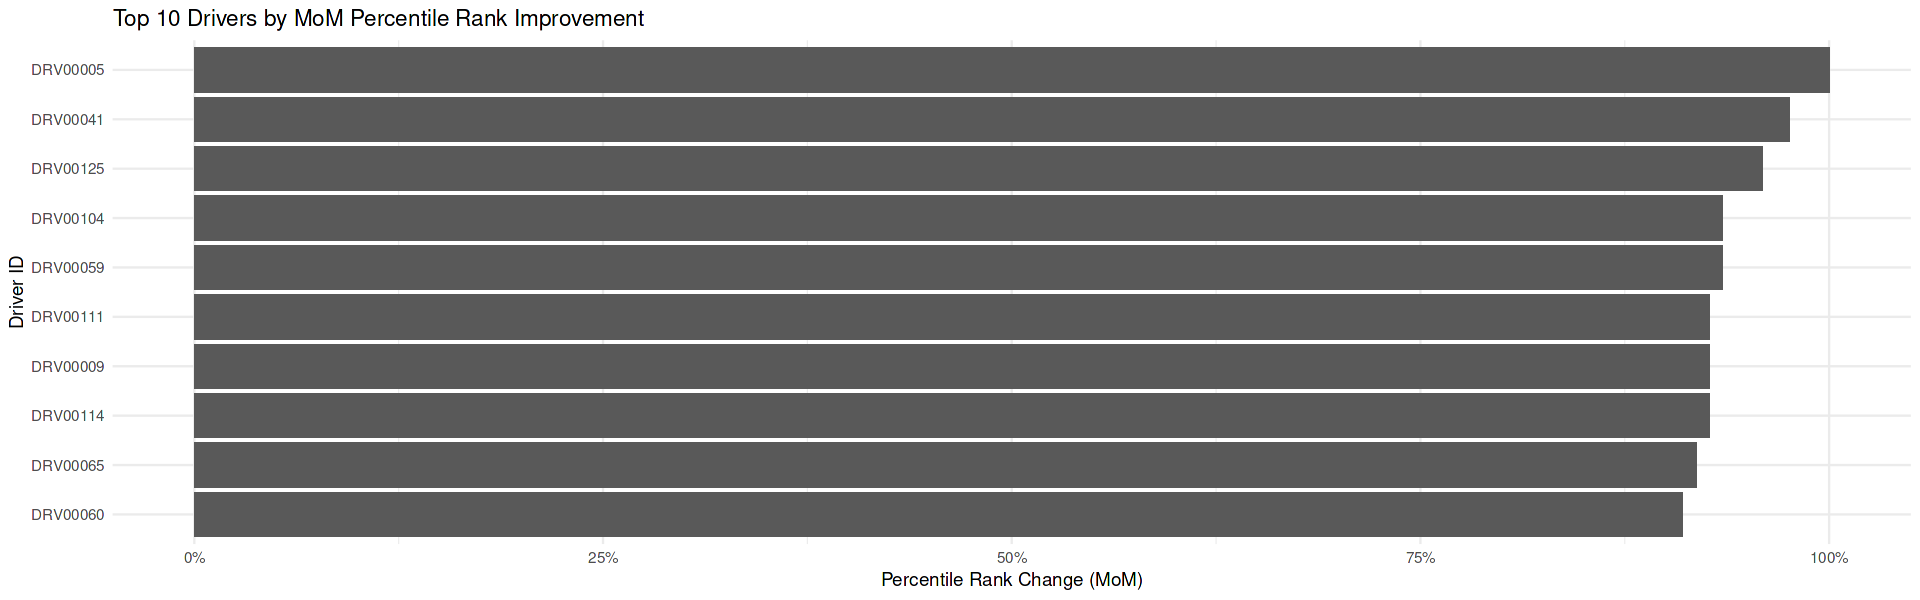

In [318]:
library(ggplot2)

pct_change %>%
  filter(!is.na(pct_rank_mom_change)) %>%
  arrange(desc(pct_rank_mom_change)) %>%
  head(10) %>%
  ggplot(aes(
    x = reorder(driver_id, pct_rank_mom_change),
    y = pct_rank_mom_change
  )) +
  geom_col() +
  coord_flip() +
  scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
  labs(
    title = "Top 10 Drivers by MoM Percentile Rank Improvement",
    x = "Driver ID",
    y = "Percentile Rank Change (MoM)"
  ) +
  theme_minimal()


# #2

# Fuel price by month

In [284]:
fuel_price_m %>%
  arrange(mon) %>%
  head(6) %>%
  mutate(`Avg Fuel Price` = scales::dollar(price, accuracy = 0.01)) %>%
  select(mon, `Avg Fuel Price`) %>%
  kable(col.names = c("Month", "Avg Fuel Price ($/gal)"))




|Month      |Avg Fuel Price ($/gal) |
|:----------|:----------------------|
|2022-01-01 |$4.21                  |
|2022-02-01 |$4.20                  |
|2022-03-01 |$4.20                  |
|2022-04-01 |$4.20                  |
|2022-05-01 |$4.20                  |
|2022-06-01 |$4.19                  |

# Maintenance cost per mile

In [257]:
maint_total <- maintenance_records %>% summarise(x=sum(total_cost, na.rm=TRUE)) %>% pull(x)
miles_total <- trips %>% summarise(x=sum(actual_distance_miles, na.rm=TRUE)) %>% pull(x)
maint_cpm <- maint_total / miles_total

print(maint_cpm)


[1] 0.0469107


# Detention cost by trip (billable minutes beyond 120)

In [282]:
library(knitr)

det_trip %>%
  mutate(
    det_min = round(det_min, 2),
    billable_hr = round(billable_hr, 2),
    detention_cost = round(detention_cost, 2)
  ) %>%
  head(10) %>%
  kable(
    col.names = c(
      "Trip ID",
      "Total Detention Minutes",
      "Billable Detention Hours",
      "Detention Cost"
    ),
    digits = 2
  )




|Trip ID      | Total Detention Minutes| Billable Detention Hours| Detention Cost|
|:------------|-----------------------:|------------------------:|--------------:|
|TRIP00000001 |                     230|                     1.83|         458.33|
|TRIP00000002 |                     129|                     0.15|          37.50|
|TRIP00000003 |                      94|                     0.00|           0.00|
|TRIP00000004 |                     192|                     1.20|         300.00|
|TRIP00000005 |                     309|                     3.15|         787.50|
|TRIP00000006 |                      22|                     0.00|           0.00|
|TRIP00000007 |                      88|                     0.00|           0.00|
|TRIP00000008 |                     177|                     0.95|         237.50|
|TRIP00000009 |                     191|                     1.18|         295.83|
|TRIP00000010 |                     389|                     4.48|        1120.83|

# lanes with highest detention spend

In [281]:
library(knitr)

lane_profit %>%
  mutate(
    revenue        = round(revenue, 2),
    detention_cost = round(detention_cost, 2),
    total_cost     = round(total_cost, 2),
    profit         = round(profit, 2),
    margin         = round(margin, 2)
  ) %>%
  arrange(desc(detention_cost)) %>%
  select(
    route_id,
    revenue,
    detention_cost,
    total_cost,
    profit,
    margin
  ) %>%
  head(10) %>%
  kable(
    digits = 2,
    col.names = c(
      "Route ID",
      "Revenue",
      "Detention Cost",
      "Total Cost",
      "Profit",
      "Margin"
    )
  )




|Route ID | Revenue| Detention Cost| Total Cost|    Profit| Margin|
|:--------|-------:|--------------:|----------:|---------:|------:|
|RTE00047 | 1595153|       536120.8|  1055031.0|  540121.6|   0.34|
|RTE00015 |  393429|       509616.7|   604091.7| -210662.7|  -0.54|
|RTE00048 | 9586537|       498862.5|  2883625.7| 6702911.2|   0.70|
|RTE00036 | 1047474|       496495.8|   763365.7|  284108.8|   0.27|
|RTE00021 | 7595328|       496220.8|  2584274.6| 5011053.9|   0.66|
|RTE00011 | 1382122|       495516.7|  1046546.8|  335575.4|   0.24|
|RTE00046 | 9501202|       495341.7|  2831536.4| 6669665.6|   0.70|
|RTE00007 | 6009333|       491358.3|  2083042.5| 3926290.8|   0.65|
|RTE00045 | 2097069|       490270.8|  1090796.6| 1006272.0|   0.48|
|RTE00014 | 3840447|       490108.3|  1691608.6| 2148838.5|   0.56|

# Lane profitability 

In [279]:
library(knitr)

lane_profit %>%
  arrange(desc(profit)) %>%
  head(10) %>%
  kable(
    digits = 2,
    col.names = c(
      "Route ID",
      "Revenue",
      "Fuel Cost",
      "Maintenance Cost",
      "Detention Cost",
      "Miles",
      "Total Cost",
      "Profit",
      "Margin"
    )
  )




|Route ID |  Revenue| Fuel Cost| Maintenance Cost| Detention Cost|   Miles| Total Cost|  Profit| Margin|
|:--------|--------:|---------:|----------------:|--------------:|-------:|----------:|-------:|------:|
|RTE00044 |  9979092|   2309981|         179103.3|       474504.2| 3817963|    2963588| 7015503|   0.70|
|RTE00016 | 10069054|   2483454|         193208.6|       469162.5| 4118647|    3145825| 6923230|   0.69|
|RTE00012 |  9757537|   2239376|         173886.2|       479066.7| 3706749|    2892328| 6865209|   0.70|
|RTE00048 |  9586537|   2213012|         171750.8|       498862.5| 3661229|    2883626| 6702911|   0.70|
|RTE00046 |  9501202|   2168113|         168082.0|       495341.7| 3583020|    2831536| 6669666|   0.70|
|RTE00029 |  9516078|   2394565|         185972.2|       464045.8| 3964388|    3044583| 6471495|   0.68|
|RTE00042 |  9070885|   2362742|         183519.7|       489208.3| 3912108|    3035470| 6035415|   0.67|
|RTE00003 |  7621381|   1863480|         144615.3|   

# * ** *Lowest-profit lanes (so you can compare)***

In [278]:
library(knitr)

lane_profit %>%
  arrange(profit) %>%
  head(10) %>%
  kable(digits = 2)




|route_id |   revenue| fuel_cost| maint_cost| detention_cost|   miles| total_cost|     profit| margin|
|:--------|---------:|---------:|----------:|--------------:|-------:|----------:|----------:|------:|
|RTE00010 |  217573.0|  83846.06|    6487.33|       486954.2|  138291|   577287.6| -359714.51|  -1.65|
|RTE00015 |  393429.0|  87678.49|    6796.52|       509616.7|  144882|   604091.7| -210662.73|  -0.54|
|RTE00033 |  600190.8| 153860.71|   11993.56|       471095.8|  255668|   636950.1|  -36759.25|  -0.06|
|RTE00036 | 1047474.5| 247634.89|   19234.93|       496495.8|  410033|   763365.7|  284108.82|   0.27|
|RTE00011 | 1382122.1| 511420.57|   39609.52|       495516.7|  844360|  1046546.8|  335575.36|   0.24|
|RTE00047 | 1595152.6| 481498.85|   37411.28|       536120.8|  797500|  1055031.0|  540121.61|   0.34|
|RTE00022 | 1542771.9| 493401.02|   38299.91|       467462.5|  816443|   999163.4|  543608.42|   0.35|
|RTE00013 | 1672332.1| 608961.07|   47443.79|       458187.5| 1011364| 

# Consecutive Declining Months

In [340]:
declining_routes %>%
  arrange(desc(months_declining)) %>%
  mutate(
    `Start Month` = format(start_month, "%b %Y"),
    `End Month`   = format(end_month, "%b %Y")
  ) %>%
  select(route_id, `Start Month`, `End Month`, months_declining) %>%
  kable(
    col.names = c(
      "Route ID",
      "Start Month",
      "End Month",
      "Consecutive Declining Months"
    )
  )




|Route ID |Start Month |End Month | Consecutive Declining Months|
|:--------|:-----------|:---------|----------------------------:|
|RTE00022 |Feb 2022    |Dec 2024  |                           21|
|RTE00031 |Feb 2022    |Dec 2024  |                           21|
|RTE00003 |Feb 2022    |Dec 2024  |                           20|
|RTE00032 |Feb 2022    |Nov 2024  |                           20|
|RTE00035 |Feb 2022    |Dec 2024  |                           20|
|RTE00053 |Feb 2022    |Dec 2024  |                           20|
|RTE00054 |Feb 2022    |Nov 2024  |                           20|
|RTE00009 |Feb 2022    |Dec 2024  |                           19|
|RTE00023 |Apr 2022    |Oct 2024  |                           19|
|RTE00030 |Feb 2022    |Nov 2024  |                           19|
|RTE00033 |Mar 2022    |Nov 2024  |                           19|
|RTE00044 |Mar 2022    |Dec 2024  |                           19|
|RTE00045 |Feb 2022    |Dec 2024  |                           19|
|RTE0000